### Text Analysis:
In this project, the predictive model for sentiment analysis is developed. The sentiment are shown into three categories:- 1) positive, 2) neutral and 3) negative. 

### Import Necessary Libraries

In [2]:
# basic libraries
import re
import json
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import pickle as pkl
from collections import Counter

#Nltk
from nltk.corpus import stopwords, words
from wordcloud import WordCloud
from num2words import num2words
from nltk.stem import WordNetLemmatizer, PorterStemmer

#sklearn
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from yellowbrick.classifier import ConfusionMatrix
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


### Load Data (Review.json)

In [6]:
## load json data 
data = []
with  open('yelp_dataset/review.json', 'r') as file:
    for f in file:
        data.append(json.loads(f))

## convert into pandas dataframe        
df = pd.DataFrame(data)
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [10]:
##takes only  review_text and stars(rating) columns
df = df[['text','stars']]
df.head()

,text,stars
0,Total bill for this horrible service? Over $8G...,1.0
1,I *adore* Travis at the Hard Rock's new Kelly ...,5.0
2,I have to say that this office really has it t...,5.0
3,Went in for a lunch. Steak sandwich was delici...,5.0
4,Today was my second out of three sessions I ha...,1.0


### 2. Text Pre-processing

The following steps are applied for text processing: <br>
&emsp;1. Replace contractions word <br>
&emsp;2. Change to lower case <br>
&emsp;3. Remove punctuation and other than alphabetic words <br>
&emsp;4. Remove stopwords and words with less than 3 letters <br>
&emsp;5. Lemmatize the words based on 'verb' POS <br>



In [138]:
## list of contractions  words
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
len(contraction_dict)

120

In [139]:
#function to find patterns of contraction words
def get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

# store contraction words and their patterns
contractions, contractions_re = get_contractions(contraction_dict)

## replace  contraction words with two-version words (e.g. 'ain't'  to 'is not')
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [141]:
#Basic text preprocessing
def clean_text(text):
    
    ## convert words to lower case 
    text = text.lower()
    
    ## replace contractions using function -  replace_contractions()
    text = replace_contractions(text)
    
    ## remove special characters and puntuaction
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = text.split()
    
    ## remove stop words and words with less than 3 letters
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
   
    ## lemmatize words based on verb 
    lema = WordNetLemmatizer()
    lema_words = [lema.lemmatize(word, pos="v") for word in text]
    text = " ".join(lema_words)
    
    return text

In [ ]:
## apply clean_text() fucntion to  column - text
df['clean_text'] = df['text'].map(lambda x: clean_text(x))
df.head(10)

### Convert into postive, netural and negative labels

I have excluded rating 4 and 2 from the data. This has been done to have clear discrimatroy words in each labels.

&emsp; 1. Positive sentiment = 5 stars rating, <br>
&emsp; 2. Neutral sentiment = 3 stars rating  <br>
&emsp; 3. Negative sentiment = 1 stars rating



In [349]:
## Exclude the rows having stars rating of  4.0 and 2.0
df = df[df['stars'].isin([1.0, 3.0, 5.0 ])]

# show in sentimen labels 
pd.options.mode.chained_assignment = None
df['sentiment'] = df['stars'].apply(lambda x: 'negative' if x ==1  else('positive'  x==5 else 'neutral'))
df_rat_tex.head()

,text,stars,sentiment
0,total bill horrible service crook actually ner...,1.0,negative
1,adore travis hard rock new kelly cardenas salo...,5.0,positive
2,say office really together organized friendly ...,5.0,positive
3,went lunch steak sandwich delicious caesar sal...,5.0,positive
4,today second three session paid although first...,1.0,negative


In [49]:
# check values counts based on labels
df_rat_tex.sentiment.value_counts()

positive    4402067
negative    1544553
neutral      739280
Name: sentiment, dtype: int64

#### Plot barchart based on labels

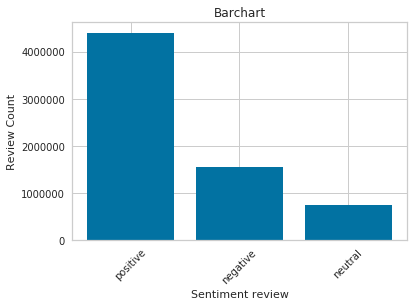

In [15]:
#plot barchart of sentiments
plt.bar(df_rat_tex.sentiment.value_counts().index, df_rat_tex.sentiment.value_counts().values )
plt.xlabel('Sentiment review')
plt.ylabel('Review Count')
plt.title('Barchart')
plt.xticks(rotation=45)
plt.show()

#Another way using panda directly
#df_rat_tex.groupby('sentiment').count()['stars'].plot.bar()

#### Obeservation: 
Positive reviews is the higest count while  negative review is half of  postive and neutral review is the least one.

/Users/gangalingden/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


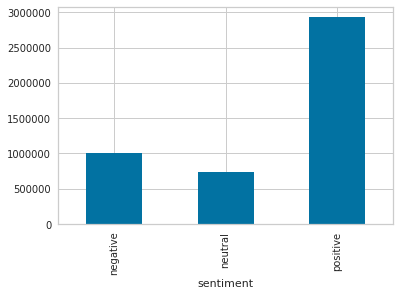

In [5]:
final_df = df_rat_tex[(df_rat_tex['stars'] != 2.0) & (df_rat_tex['stars'] != 4.0)]
final_df.groupby('sentiment').count()['stars'].plot.bar()

In [6]:
final_df.sentiment.value_counts()

positive    2933082
negative    1002159
neutral      739280
Name: sentiment, dtype: int64

#### 2.8 Define Vocabulary

In [350]:
#define vocabulary 
vocab = Counter()
for text in df_rat_tex.loc[:, 'text']:
    vocab.update(text.split())
        
    

In [8]:
# define function to generate word cloud

def generate_wordcloud(text, title=None):
    '''
    text = collection of words to plot.
    title = title of figure.
    this function returns word cloud image
    '''
    cloud = WordCloud(max_font_size=30, max_words= 200, 
                      background_color="white", scale=2,
                     collocations=False).generate(str(text))
    
    plt.figure( figsize=(12,10)) # set size of figure
    
    if title: # if title is given use it
        plt.title(title, fontdict={'size': 20,  
                                  'verticalalignment': 'bottom'})
     
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()
    


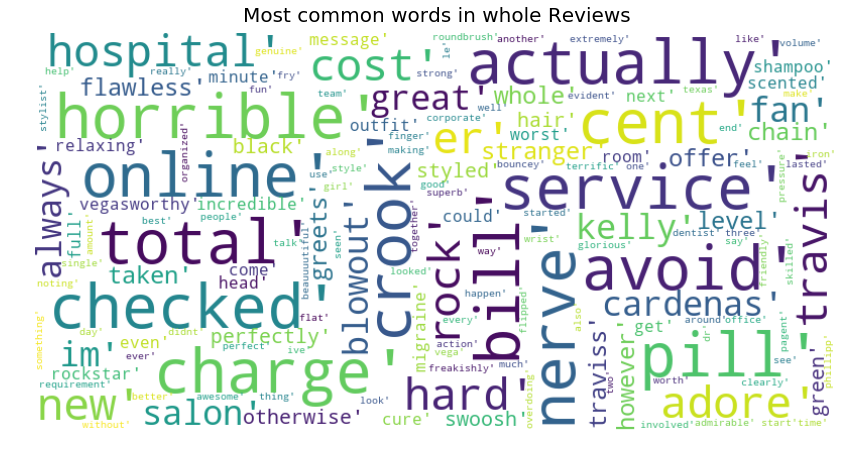

In [109]:
#call generate_wordcloud function
tokens =[ word for word, count  in vocab.items()]
generate_wordcloud(tokens, 'Most common words in whole Reviews')

#### 2.9 Separate Sentiments

In [7]:
# separate sentiment and  show in word cloud
negative_sentiment = ' '.join( review for review in df_rat_tex.loc[df_rat_tex['sentiment'] == 'negative']['text'])
postive_sentiment = ' '.join( review for review in df_rat_tex.loc[df_rat_tex['sentiment'] == 'positive']['text'])
neutral_sentiment = ' '.join( review for review in df_rat_tex.loc[df_rat_tex['sentiment'] == 'neutral']['text'])

CPU times: user 6 µs, sys: 6 µs, total: 12 µs
Wall time: 36 µs


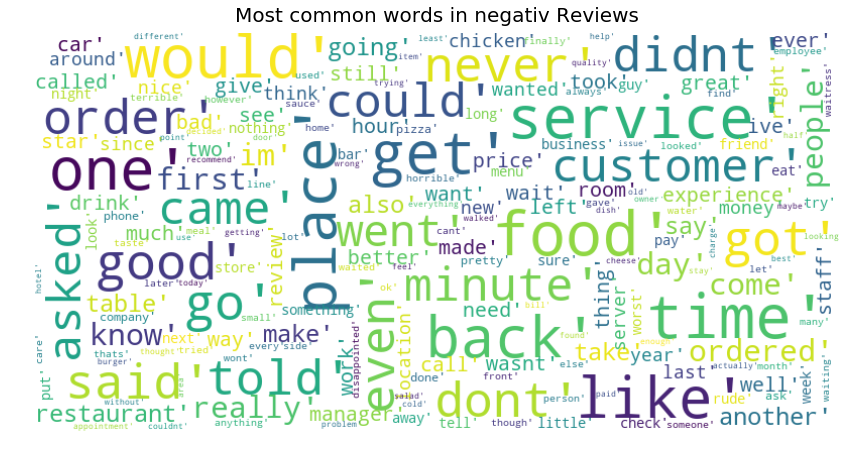

In [10]:
#show negative Reviews in word cloud
%time
ng_token = [ word for word in negative_sentiment.split()]
generate_wordcloud(ng_token, 'Most common words in negativ Reviews')

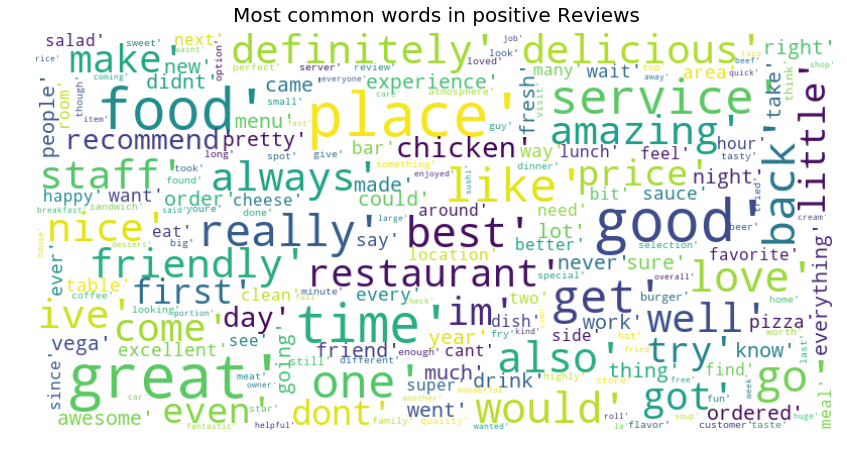

In [14]:
# show positive reviews in wordcloud
pos_token = [ word for word in postive_sentiment.split()]
generate_wordcloud(pos_token, 'Most common words in positive Reviews')

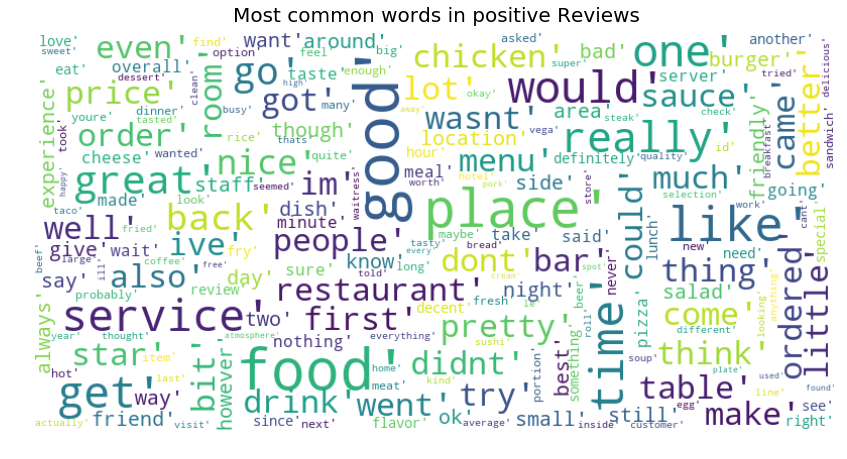

In [15]:
# show neutral reviews in wordcloud
neu_token = [ word for word in neutral_sentiment.split()]
generate_wordcloud(neu_token, 'Most common words in positive Reviews')

In [253]:
# remove top 2 most occurance word and  low occurrence
min_occurence =5
#vocab_list = vocab.most_common()[2:]
tokens =[ word for word, count  in vocab.items() if count > min_occurence]
print(len(tokens))


205154


In [7]:
final_df.sentiment.value_counts()

positive    2933082
negative    1002159
neutral      739280
Name: sentiment, dtype: int64

In [13]:
rd = RandomUnderSampler(random_state=2)
X,y = rd.fit_resample(final_df[['text', 'stars']], final_df['sentiment'])

In [17]:
final_data = pd.DataFrame(X)
final_data.head()


,0,1
0,bought new tire rim beginning year went back a...,1
1,super vega hotel reroute entire strip luxor wo...,1
2,keeping short numerous people said greater det...,1
3,went large group mother day brunch trying thin...,1
4,dollar beer battered cod fry coleslaw fish loo...,1


### 3. Feature Generation using Bag of Words


In [134]:
# generates word in feature matrix
cv = CountVectorizer(lowercase=True,stop_words='english', ngram_range = (1,2), min_df=0.005)
text_counts= cv.fit_transform(final_data[0])


In [ ]:
cv.get_features()

In [ ]:
%%time
tf_idf = TfidfVectorizer(lowercase=True,stop_words='english',  min_df = 0.005, ngram_range = (1,3), norm ='l2')
tf_text_count= tf_idf.fit_transform(final_data[0])


In [113]:
model = MultinomialNB().fit(text_counts, y)

In [131]:
data = ['bad food']
text_matrix = cv.transform(data)

In [132]:
model.predict(text_matrix)

array(['neutral'], dtype='<U8')

In [379]:
# optimize the preprocessing
fea_object =[('vect', TfidfVectorizer(ngram_range=(1,2))),
             ('naive', MultinomialNB())]

pipe = Pipeline(fea_object)
#'vect__max_df': np.linspace(0.0005, 0.05, 3), #max_df
#'vect__max_df': [0.98, 0.95, 0.93, 0.9], #max_df
# set parameters
parameter = { 'vect__min_df' : [0.0005, 0.0025, 0.005, 0.025, 0.05 ], # min_df
              
            }

# construct grid search  object
grid_object = GridSearchCV(pipe, param_grid= parameter, cv = StratifiedKFold(n_splits =5, shuffle = True))

In [380]:
%%time
#fit the data
grid_object.fit(final_data[0], y)
print(grid_object.best_score_)
print(grid_object.best_params_)

0.8079198679796559
{'vect__min_df': 0.0005}
CPU times: user 5h 55min 10s, sys: 1h 5min 28s, total: 7h 38s
Wall time: 8h 4min 41s


In [39]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, y, test_size=0.3, random_state=1, shuffle = True, stratify = y)



In [40]:
#build model Using Multinomial Naive Bayes
def Naiv_Baye_classifer( X_train, y_train, X_test, y_test):
    '''
    return classification accuracy
    and classification report
    '''
    clf = MultinomialNB().fit(X_train, y_train)
    predicted= clf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    
    target_name = np.unique(y_train)
    classi_report = classification_report(y_test, predicted, target_names= target_name)
    conf_matrix = confusion_matrix(y_test, predicted)
    print('Accuracy is: ', accuracy)
    print(classi_report)
    print(conf_matrix)

In [41]:
Naiv_Baye_classifer( X_train, y_train, X_test, y_test)

Accuracy is:  0.7158797147975808
              precision    recall  f1-score   support

    negative       0.75      0.70      0.73    221784
     neutral       0.60      0.71      0.65    221784
    positive       0.83      0.74      0.78    221784

   micro avg       0.72      0.72      0.72    665352
   macro avg       0.73      0.72      0.72    665352
weighted avg       0.73      0.72      0.72    665352

[[155731  61511   4542]
 [ 35201 156938  29645]
 [ 16633  41508 163643]]


In [217]:
Naiv_Baye_classifer( X_train, y_train, X_test, y_test)

Accuracy is:  0.7757893566112374
              precision    recall  f1-score   support

    negative       0.79      0.79      0.79    221784
     neutral       0.67      0.79      0.73    221784
    positive       0.90      0.74      0.81    221784

   micro avg       0.78      0.78      0.78    665352
   macro avg       0.79      0.78      0.78    665352
weighted avg       0.79      0.78      0.78    665352

[[176106  43011   2667]
 [ 30233 175864  15687]
 [ 15365  42216 164203]]


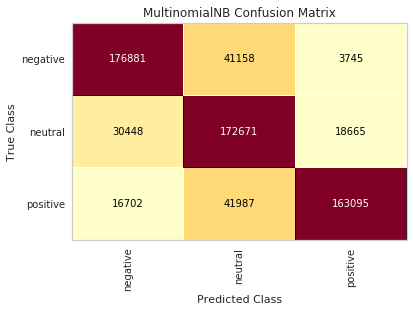

In [378]:
clf = MultinomialNB()
cm = ConfusionMatrix(clf, classes= np.unique(y_train))
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

In [79]:
y_test.value_counts()

positive    1320620
negative     463366
neutral      221784
Name: sentiment, dtype: int64

In [252]:
%%time
naive = MultinomialNB()
final_score = 0
min_val = 0
for x in range(1, 6):
    min_occurence =x
    #vocab_list = vocab.most_common()[2:]
    tokens =[ word for word, count  in vocab.items() if count > min_occurence]

    tf_idf = TfidfVectorizer(lowercase=True,stop_words='english', vocabulary= tokens, ngram_range = (1,1), norm ='l2')
    tf_text_count= tf_idf.fit_transform(final_data[0])
    
    score =cross_val_score (naive,X= tf_text_count, y=y, cv =StratifiedKFold(n_splits =10, shuffle = True) )
    avg_score = score.mean()
    
    if   avg_score > final_score:
        final_score = avg_score
        min_val =x

print(final_score)
print(min_val)

0.7761118926523103
5
CPU times: user 21min 50s, sys: 2min 5s, total: 23min 56s
Wall time: 23min 40s


In [37]:
naive = MultinomialNB()
score =cross_val_score (naive,X= text_counts, y=y, cv =StratifiedKFold(n_splits =10, shuffle = True) )
avg_score = score.mean()
print(avg_score)

0.7156242109439817


In [ ]:
0.7697065613389605

#### Save the process files 

In [54]:
# define function tosave the file/model in the disk
def save_file(model, file_name):
    '''
    model = file/model to save
    file_name = name given to model/file
    '''
    pkl.dump(model, open(file_name, 'wb'))
 


In [55]:
#call function
save_file(model, 'model.nlp')

#### load the saved file

In [2]:
loaded_file = pkl.load(open('processed.sav', 'rb'))

In [4]:
vocab =pkl.load(open('vocab.txt', 'rb'))

In [3]:
df_rat_tex =loaded_file

In [63]:
save_file(tf_idf, 'tf_idf.nlp')
save_file(tf_text_count, 'tf_text_count.nlp')


In [65]:
!du -h tf_text_count.nlp

876M	tf_text_count.nlp


In [66]:
!zip -r tf_text.zip tf_idf.nlp

  adding: tf_idf.nlp (deflated 55%)


In [67]:
!du -h tf_text.zip

224M	tf_text.zip
